Plot info about Allen dataset subset that we use.

We use 8 areas: 6 visual cortical areas (V1, LM, AL, RL, AM, PM) and 2 thalamic (LGN, LP).

below mapping from Rudelt at el (found in github code):
    structures = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam", "LGd", "LP"]
    structures_names = ["V1", "LM", "RL", "AL", "PM", "AM", "LGN", "LP"]

Plots based on 30min dataset (trimmed beforehand).

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# import from scripts
import os
current_wd = os.getcwd()
os.chdir(os.path.abspath("..\\..\\..\\isttc\\scripts"))
from cfg_global import project_folder_path
os.chdir(current_wd)

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
dataset_folder = project_folder_path + 'results\\mice\\dataset\\'
fig_folder = project_folder_path + 'results\\mice\\fig_draft_paper\\'

In [4]:
# the order is like in Siegle paper
brain_areas = ['LGd', 'VISp', 'VISl', 'VISrl', 'LP', 'VISal', 'VISpm', 'VISam']
brain_areas_names = ['LGN', 'V1', 'LM', 'RL', 'LP', 'AL', 'PM', 'AM']

# quality thresholds
amplitude_cutoff = 0.01 # Allen default is 0.1, this one is from Rudelt
isi_violations = 0.5 # default Allen
presence_ratio = 0.9 # default Allen

quality_query = 'amplitude_cutoff < @amplitude_cutoff and isi_violations < @isi_violations and presence_ratio > @presence_ratio'

### Get data

In [5]:
regenerate = False

min_to_keep = 30

In [6]:
if regenerate:
    csv_data_file = dataset_folder + 'cut_' + str(min_to_keep) + 'min\\sua_list.csv'
    with open(csv_data_file, newline='') as f:
        reader = csv.reader(f)
        sua_list = list(reader)
    print(f'Loaded N units {len(sua_list)}')
    
    column_names = ["specimen_id", "session_id", "unit_id", "ecephys_structure_acronym", 'firing_rate', 'amplitude_cutoff', 'isi_violations', 'presence_ratio']
    units_df = pd.DataFrame([row[:8] for row in sua_list], columns=column_names)
    units_df[['firing_rate', 'amplitude_cutoff', 'isi_violations', 'presence_ratio']] = \
        units_df[['firing_rate', 'amplitude_cutoff', 'isi_violations', 'presence_ratio']].astype(float)
    n_spikes_l = [len(row[8:]) for row in sua_list]
    fr_hz_spont_min_l = [n_spikes / (min_to_keep * 60) for n_spikes in n_spikes_l]
    units_df['fr_hz_spont_min'] = fr_hz_spont_min_l
    units_df['fr_hz_spont_min_log10'] = np.log10(units_df['fr_hz_spont_min'])
    print(f'N units from all areas {len(units_df)}')
    
    units_subset_df = units_df[units_df['ecephys_structure_acronym'].isin(brain_areas)].copy()
    print(f'N units from 8 areas {len(units_subset_df)}')
    
    units_subset_df_quality = units_subset_df.query(quality_query).copy()
    print(f'N units from 8 areas constraints by quality metrics {len(units_subset_df_quality)}')

    included_units = units_subset_df_quality['unit_id'].values
    sua_list_subset = [row for row in sua_list if row[2] in included_units]

    verbose = False
    output_filename = dataset_folder + 'cut_' + str(min_to_keep) + 'min\\sua_list_constrained.csv'
    with open(output_filename, 'a', newline='') as f:
        writer = csv.writer(f)
        for unit in sua_list_subset:
            if verbose:
                print('Writing unit {}'.format(unit[2]))
            writer.writerow(unit)
else:
    units_subset_df_quality = pd.read_pickle(dataset_folder + 'cut_' + str(min_to_keep) + 'min\\sua_list_constrained_units_df.pkl')

### Plot

In [7]:
units_subset_df_quality

,specimen_id,session_id,unit_id,ecephys_structure_acronym,firing_rate,amplitude_cutoff,isi_violations,presence_ratio,fr_hz_spont_30min,fr_hz_spont_30min_log10
66,744912849,766640955,950913540,VISam,5.924830,0.004951,0.157933,0.99,6.038333,0.780917
67,744912849,766640955,950915005,VISam,4.549072,0.001203,0.096072,0.99,4.030556,0.605365
68,744912849,766640955,950915018,VISam,1.202348,0.007743,0.052895,0.99,1.903333,0.279515
71,744912849,766640955,950913798,VISam,0.804217,0.003652,0.236458,0.99,1.045556,0.019347
76,744912849,766640955,950915049,VISam,0.729141,0.002677,0.071915,0.96,0.953889,-0.020502
...,...,...,...,...,...,...,...,...,...,...
18157,827809884,847657808,951190507,VISrl,2.064394,0.003058,0.089377,0.99,2.644444,0.422334
18159,827809884,847657808,951190510,VISrl,1.421316,0.001375,0.037710,0.99,0.751667,-0.123975
18162,827809884,847657808,951190529,VISrl,5.650508,0.000566,0.072772,0.99,5.059444,0.704103
18165,827809884,847657808,951190848,VISrl,0.942361,0.004080,0.343136,0.99,0.303889,-0.517285


In [19]:
save_fig = True

#### Number of units per area

In [10]:
counts = units_subset_df_quality.groupby('ecephys_structure_acronym')['specimen_id'].nunique()
counts

ecephys_structure_acronym
LGd      12
LP       20
VISal    20
VISam    24
VISl     18
VISp     24
VISpm    16
VISrl    22
Name: specimen_id, dtype: int64

In [11]:
counts = units_subset_df_quality['specimen_id'].nunique()
counts

26

In [12]:
units_per_area_df = units_subset_df_quality.groupby(by='ecephys_structure_acronym', as_index=False)['unit_id'].count()
units_per_area_df.rename(columns={'unit_id':'n_units'}, inplace=True)
units_per_area_df

,ecephys_structure_acronym,n_units
0,LGd,254
1,LP,599
2,VISal,928
3,VISam,912
4,VISl,727
5,VISp,1063
6,VISpm,586
7,VISrl,706


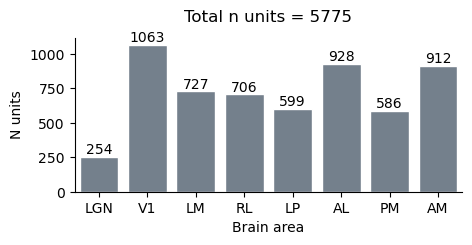

In [20]:
fig, axes = plt.subplots(1,1, figsize=(5,2))

sns.barplot(ax=axes, x='ecephys_structure_acronym', y='n_units', data=units_per_area_df, 
            color='slategray', edgecolor='white', order=brain_areas)
labels = [str(int(v)) if v else '' for v in axes.containers[0].datavalues]
axes.bar_label(axes.containers[0], labels=labels)
axes.set_xlabel('Brain area')
axes.set_ylabel('N units')
axes.set_xticks(brain_areas)
axes.set_xticklabels(brain_areas_names)

axes.set_title(f'Total n units = {len(units_subset_df_quality)}', y=1.05)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'n_units_per_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'n_units_per_area.svg' , bbox_inches='tight')

#### Firing rate per area

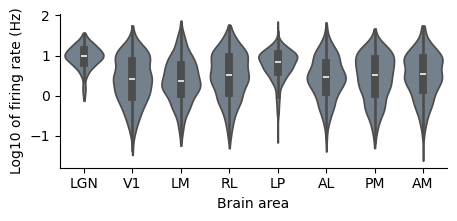

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(5,2))

sns.violinplot(ax=axes, x='ecephys_structure_acronym', y='fr_hz_spont_30min_log10', data=units_subset_df_quality, 
               cut=0, density_norm='width', color='slategray', order=brain_areas)
axes.set_xlabel('Brain area')
axes.set_ylabel('Log10 of firing rate (Hz)')
axes.set_xticks(brain_areas)
axes.set_xticklabels(brain_areas_names)

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'fr_per_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'fr_per_area.svg' , bbox_inches='tight')

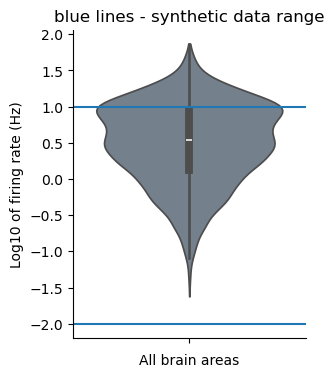

In [23]:
fig, axes = plt.subplots(1, 1, figsize=(3,4))

sns.violinplot(ax=axes, y='fr_hz_spont_30min_log10', data=units_subset_df_quality, 
               cut=0, density_norm='width', color='slategray')
axes.set_xlabel('All brain areas')
axes.set_ylabel('Log10 of firing rate (Hz)')
axes.axhline(y=np.log10(0.01))
axes.axhline(y=np.log10(10))
axes.set_title('blue lines - synthetic data range')

sns.despine()

if save_fig:
    plt.savefig(fig_folder + 'fr_all_area.png' , bbox_inches='tight', dpi=300)
    plt.savefig(fig_folder + 'fr_all_area.svg' , bbox_inches='tight')